The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 0.98, 'Variance Gamma Process')

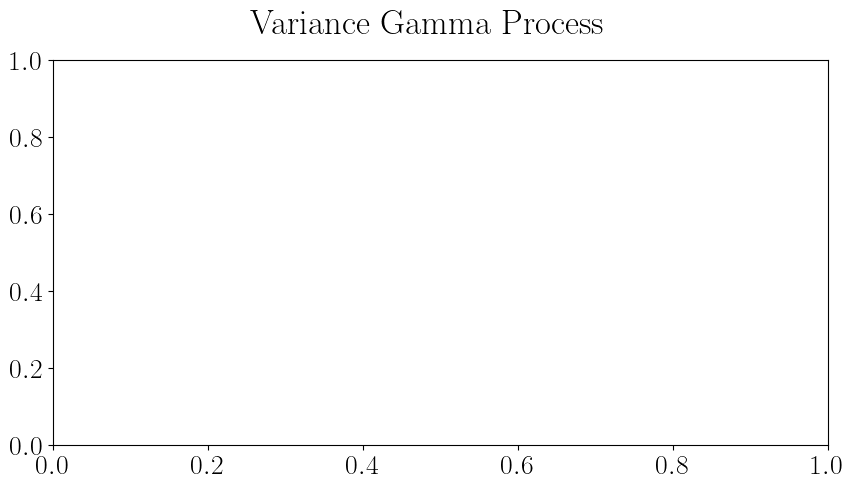

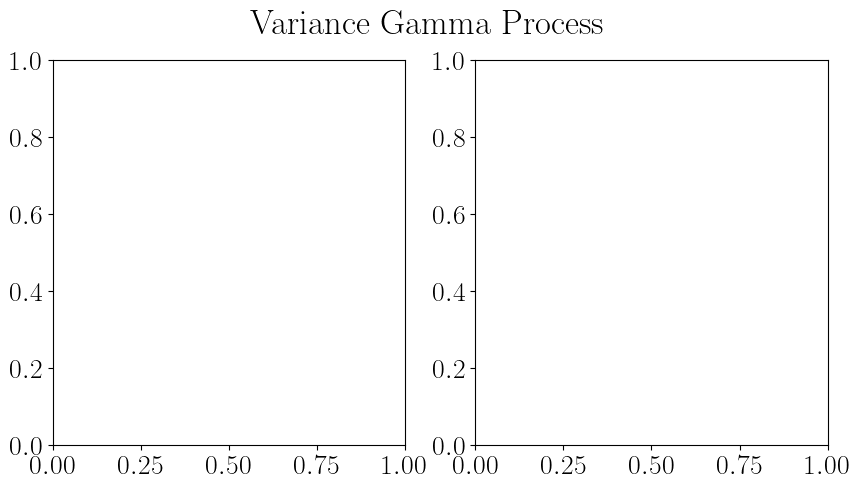

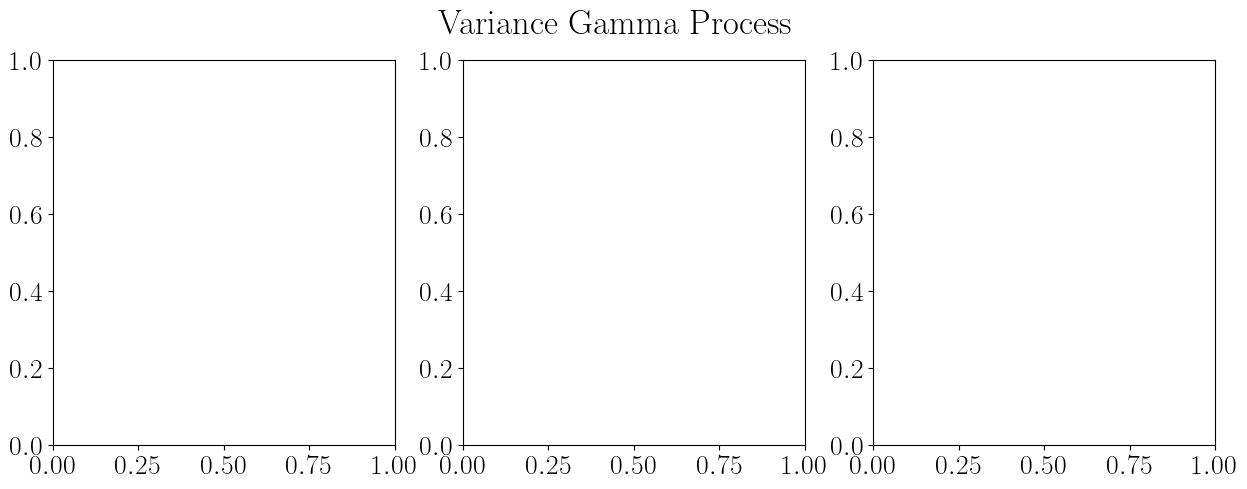

In [44]:
%load_ext autoreload
%autoreload 2

from utility import format_plt, symmetric_stable_scaling_factor, plot_gnvm_residuals, save_fig, plot_gnvm_process_1d
import matplotlib.pyplot as plt

font_size = 20
format_plt(font_size=font_size)

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))  
fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  
fig1.suptitle(r"Variance Gamma Process", fontsize=25)
fig2.suptitle(r"Variance Gamma Process", fontsize=25)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  
fig.suptitle(r"Variance Gamma Process", fontsize=25)

In [45]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.driver import GammaNVMDriver
from stonesoup.models.transition.driven import Process
from datetime import datetime, timedelta
import numpy as np

# And the clock starts
start_time = datetime.now().replace(microsecond=0)
seed = 53

mu_W = 0.5
sigma_W2 = 1
# gamma = np.sqrt(2.)
nu = 1
beta = nu
print(f"{beta:.3f}")
noise_case=2
c=50

gamma_driver = GammaNVMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=c, nu=nu, beta=beta, noise_case=noise_case)
transition_model = Process(cg_driver=gamma_driver)

timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0], timestamp=timesteps[0])])

num_steps = 10000
for k in range(1, num_steps + 1):
    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

1.000


In [37]:
# xtest = np.linspace(-10, 10, 100)
# pdf = gamma_driver.pdf(xtest) 
# pdf = pdf.flatten()

# y = np.diff([data.state_vector[0] for data in truth])

# plt.plot(xtest, pdf)
# plt.hist(y, density=True, bins='auto')
# print()

KstestResult(statistic=nan, pvalue=nan, statistic_location=0.8435933199321933, statistic_sign=-1)

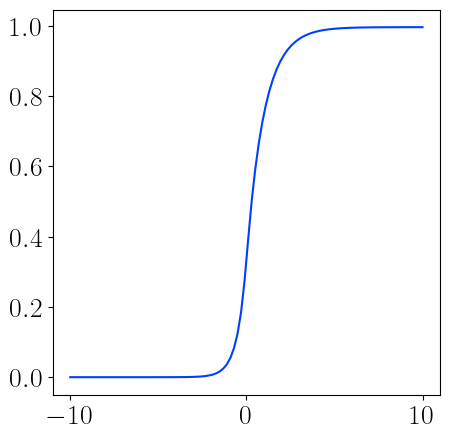

In [38]:
from scipy.stats import levy_stable, norm, kstest

from scipy.integrate import cumulative_trapezoid


def cdf(pdf_func):
    return lambda x: cumulative_trapezoid(pdf_func(x), x=x, axis=-1, initial=0.0).flatten()

print()
plt.plot(xtest, cdf(gamma_driver.pdf)(xtest).flatten())
kstest(y, cdf(gamma_driver.pdf), N=1) 

In [39]:
ax1.clear()
xlabel = r"$t$"
ylabel = r"$W^c(t)$"
cutoff = 50
# num_steps = 10000


mu_W = 0.5
sigma_W2 = 1
# gamma = np.sqrt(2.)
beta = 1
print(f"{beta:.3f}")
noise_case=2
c=50



for nu in (0.5, 2, 3):
    timesteps = [start_time]
    more_truths = GroundTruthPath([GroundTruthState([0], timestamp=timesteps[0])])
    gamma_driver = GammaNVMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=c, nu=nu, beta=beta, noise_case=noise_case)
    transition_model = Process(cg_driver=gamma_driver)
    
    for k in range(1, num_steps + 1):
        timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
        more_truths.append(GroundTruthState(
            transition_model.function(more_truths[k-1], noise=True, time_interval=timedelta(seconds=1)),
            timestamp=timesteps[k]))  

        
    y = np.array([data.state_vector[0] for data in more_truths])
    ax1.plot(y[:cutoff], color='k')
    # fig1 = plot_gnvm_process_1d(fig, ax1, truth=more_truths[:100], title="Truncated Sample Paths", xlabel=xlabel, ylabel=ylabel, beta=beta, nu=nu)


ax.plot(y, color='k', label=r"VG Process")
ax.plot(x, linestyle='dotted', color='k', label=r"Gaussian process")
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
fig.tight_layout()

fig1 = plot_gnvm_process_1d(fig1, ax1, truth=truth[:cutoff], title="Truncated Sample Paths", xlabel=xlabel, ylabel=ylabel, beta=beta, nu=nu)
fig1

1.000


NameError: name 'ax' is not defined

In [46]:
fig= plot_gnvm_process_1d(fig, ax1, truth=more_truths[:100], title="Truncated Sample Paths", xlabel=xlabel, ylabel=ylabel, beta=beta, nu=nu)


In [12]:
# save_fig(fig1, "gamma_process")

KS test p-value: 0.6802309329871867


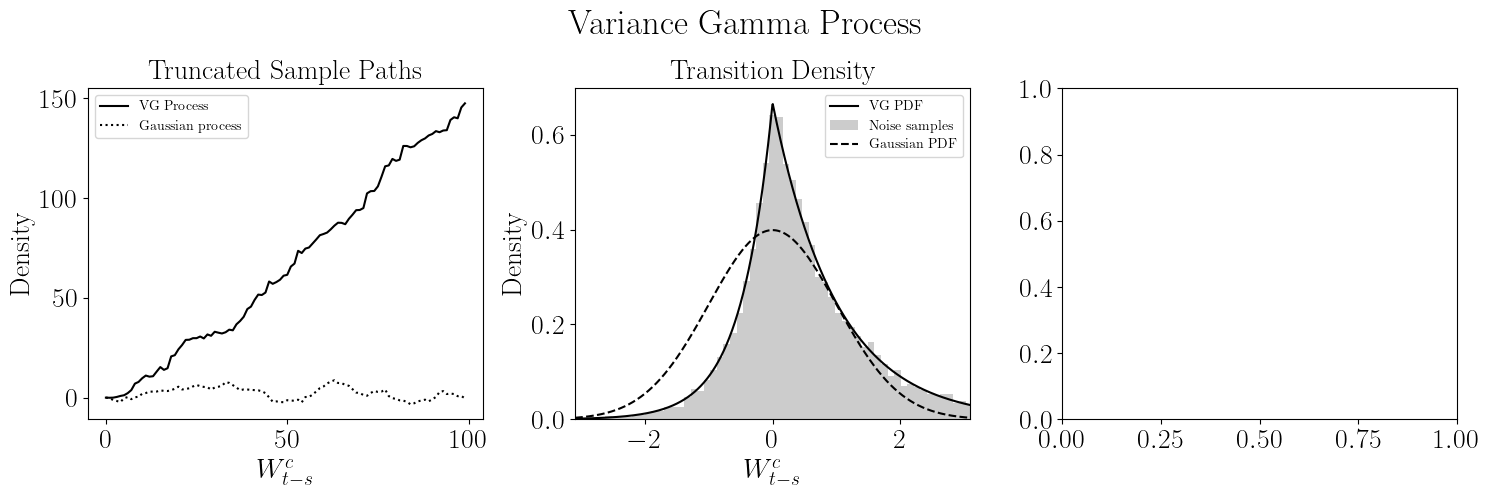

In [47]:
from scipy.stats import levy_stable, norm, kstest

ax2.clear()
xlabel = r"$W^c_{t-s}$"
ylabel = r"Density"
title = "Transition Density"

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000)
pdf = gamma_driver.pdf(x).flatten()

y = np.diff([data.state_vector[0] for data in truth])
results = kstest(y, cdf(gamma_driver.pdf),  N=num_steps) 
print("KS test p-value:", results.pvalue)
ax2.plot(x, pdf, '-', label="VG PDF", color='k')
ax2.hist(y, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="k", label="Noise samples")
ax2.plot(x, norm.pdf(x), '--', label='Gaussian PDF', color="k")    

ax2.set_xlim([x[0], x[-1]])
ax2.set_title(title)
ax2.set_xlabel(xlabel)
ax2.set_ylabel(ylabel)
ax2.legend()
fig.tight_layout()
fig



In [139]:
# save_fig(fig2, "gamma_transition_density")

KstestResult(statistic=0.19854409854882657, pvalue=0.0, statistic_location=-0.3471372671820596, statistic_sign=-1)


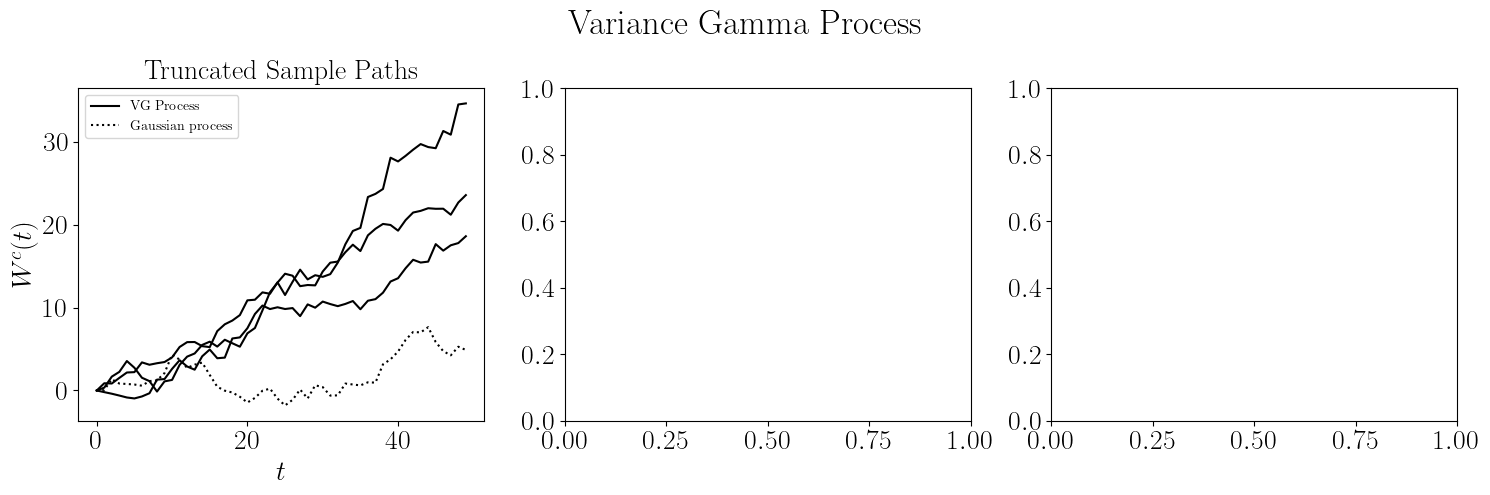

In [42]:
from stonesoup.models.transition.base_driver import Latents
import matplotlib.pyplot as plt
# Investigate residuals

ax3.clear()
upper_limit = 100
# lower_limit = 5
gd = GammaNVMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=upper_limit, nu=nu, beta=beta)
dt = 1
n_latents=10000
ft = lambda dt, jtimes: np.ones_like(jtimes)[..., None, None]
e_ft = lambda dt: dt * np.ones((1, 1))
sizes, times = gd.sample_latents(dt=dt, num_samples=n_latents)
residual_jsizes = sizes[c:]
residual_jtimes = times[c:]
# print(residual_jsizes.shape)
latents = Latents(num_samples=n_latents)
latents.add(gd, residual_jsizes, residual_jtimes)

mean = gd.mean(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents)
covar = gd.covar(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents)
rvs = []
for i in range(n_latents):
    tmp = gd.rvs(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents, covar=covar[i], mean=mean[i], num_samples=1)
    rvs.append(tmp[0])
y = np.array(rvs)
y = (y - y.mean()) / y.std()
results = kstest(y, norm.cdf, N=n_latents) 
print(results)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)


ax3.hist(y, density=True, bins='auto', label='VG Residuals', histtype='stepfilled', alpha=0.2, color='k')
ax3.plot(x, norm.pdf(x), '--', label='Gaussian PDF', color='k')    
ax3.set_title(r"Normalised Residual Density")
ax3.set_xlabel(r"$\bar R^c_{t-s}$")
ax3.set_ylabel(r"Density")
ax3.legend()
ax3.set_xlim((-5, 5))
ax3.set_ylim((0, 1))
fig.tight_layout()
fig

In [157]:
save_fig(fig, "gamma_gathered")

# Plotting noise samples

In [20]:
# from scipy.stats import levy_stable, norm

# y = np.array([data.state_vector[0] for data in truth])
# fig, ax = plt.subplots(nrows=1, ncols=1)
# alpha, beta = 1.99999, 0
# x = np.linspace(levy_stable.ppf(0.001, alpha, beta),
#                 levy_stable.ppf(0.999, alpha, beta), 100)
# _ = ax.plot(x, levy_stable.pdf(x, alpha, beta), 'r-', lw=5, alpha=0.6, label='levy_stable pdf')    
# x = np.linspace(levy_stable.ppf(0.001, alpha, beta),
#                 levy_stable.ppf(0.999, alpha, beta), 100)
# _ = ax.plot(x, norm.pdf(x), 'g-', lw=5, alpha=0.6, label='normal pdf')    
# _ = ax.hist(np.diff(y), density=True, bins=50, histtype='stepfilled', alpha=0.6)
# ax.set_xlim([x[0], x[-1]])


In [10]:
# from stonesoup.models.transition.base import CombinedLinearDrivenTransitionModel

# # And the clock starts
# start_time = datetime.now().replace(microsecond=0)
# seed = 1991

# mu_W = 0
# sigma_W2 = 2

# as_driver = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=10, alpha=1.99)
# process_x = Process(cg_driver=as_driver)
# process_y = Process(cg_driver=as_driver)
# transition_model = CombinedLinearDrivenTransitionModel([process_x, process_y])


# timesteps = [start_time]
# truth = GroundTruthPath([GroundTruthState([0, 0], timestamp=timesteps[0])])

# num_steps = 1000
# for k in range(1, num_steps + 1):
#     timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
#     truth.append(GroundTruthState(
#         transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
#         timestamp=timesteps[k]))

In [11]:
# t = np.array([(data.timestamp - start_time).total_seconds() for data in truth])
# t -= t[0]
# y0 = np.array([data.state_vector[0] for data in truth])
# y1 = np.array([data.state_vector[1] for data in truth])

# fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

# ax1.plot(t, y0)
# ax2.plot(t, y1)